# Seminar 5. Hypothesis testing

In this seminar we will use following packages:

[scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) and [statsmodels](https://www.statsmodels.org/dev/index.html)

In [50]:
import numpy as np
import scipy.stats as sps

import statsmodels as sm
import statsmodels.api as sma

In [51]:
# Matplotlib settings
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset']='cm'
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

Partialy based on materials by Jose D. Perezgonzalez.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4347431/

## Fisher's approach to hypothesis testing

1. Select an appropriate test baed nature of the data and experiment design
2. Define the model of the data under null hypothesis $H_0$
3. Calculate the theoretical probability of observing the given data under $H_0$: $p$-value

Can perform analysis after the data is collected, can asses significance of the results using $p$-value.

### Example: normal-based testing

Given a sample $X_1, X_2, \dots, X_n \sim \mathcal{N}(\mu, \sigma)$ and a fixed value $\mu_0$, test the hypothesis $H_0: \; \mathbb{E}[X] = \mu_0$.

Construct a *pivotal quantity*: a function of data and parameters whose **distribution** does not depend on the unknown parameters.

$$T = \frac{\sqrt{n}\left(\overline{X}_n - \mu_0\right)}{\sigma} \sim \mathcal{N}(0, 1).$$

Test: reject $H_0$ if $|T|> c = z_{\alpha/2}$.

True
mu_0 = 0.1, mu = 0.5, Probability of type II error (beta) = 0.028000000000000025
Got statistic = 3.142 with p-value = 0.0016799795860232994. Reject H0


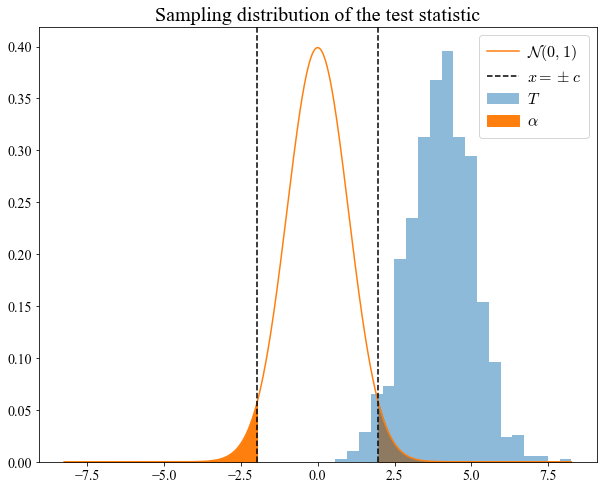

In [52]:
size = 100
mean, std = 0.5, 1
dist = sps.norm(loc=mean, scale=std)
T = lambda sample, hypothesis_mean, std: (np.mean(sample) - hypothesis_mean) * np.sqrt(len(sample)) / std

alpha = 0.05
c = sps.norm.ppf(1 - alpha / 2)
h0_mean = 0.1

nruns = 1000
r = np.zeros(nruns)
r1 = np.zeros(nruns)
t = np.empty(nruns)

for i in range(nruns):
    x = dist.rvs(size)
    
    t[i] = T(x, h0_mean, std)
    statistic = np.abs(t[i])
    pvalue = 2 * sps.norm.cdf(-np.abs(statistic))
    r[i] = int(pvalue < 0.05)
    r1[i] = int(statistic > c)

print(np.isclose(r.mean(), r1.mean()))

print(f"mu_0 = {h0_mean}, mu = {mean}, Probability of type II error (beta) = {1 - r.mean()}")
    
print(f"Got statistic = {statistic:.3f} with p-value = {pvalue}. {'Reject' if statistic > c else 'Fail to reject'} H0")

u = np.linspace(-t.max(), t.max(), 1000)
plt.figure(figsize=(10, 8))
plt.title("Sampling distribution of the test statistic")
plt.hist(t, density=True, bins=20, alpha=0.5, color="C0", label=r"$T$")
plt.plot(u, sps.norm.pdf(u), color="C1", label=r"$\mathcal{N}(0, 1)$")
r = u[u>=c]
plt.fill_between(r, sps.norm.pdf(r), color="C1", label=r"$\alpha$")
plt.fill_between(-r, sps.norm.pdf(-r), color="C1")
plt.axvline(x=c, color="k", ls="--", label=r"$x=\pm c$")
plt.axvline(x=-c, color="k", ls="--")
plt.legend()
plt.show()

### Example: Student $t$-test
[docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html#scipy.stats.ttest_1samp)

Test if the population mean is equal to the value specified by $H_0$.

We will use the El-Nino hurricane data. Let's test for column **APR** the hypothesis that sample mean over first 10 years is close to sample mean for all years.

In [ ]:
elnino_data = sma.datasets.elnino.load_pandas().data
elnino_data.drop("YEAR", axis=1, inplace=True)
elnino_data.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30


In [ ]:
f"Overall number of years {len(elnino_data)}"

'Overall number of years 61'

array([[<AxesSubplot:title={'center':'APR'}>]], dtype=object)

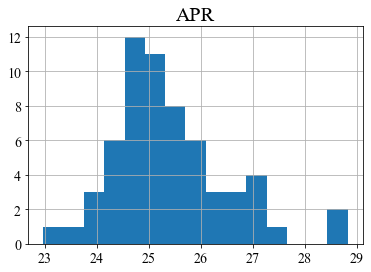

In [ ]:
elnino_data.hist("APR", bins=15)

In [ ]:
# 25.386
estimation_period = 10 # years
x = elnino_data["APR"].values
hypothesis_mean = np.mean(x[:estimation_period])

statistic, pvalue = sps.ttest_1samp(x, hypothesis_mean)
f"Got statistic = {statistic:.3f} with p-value = {pvalue:.3f}"

'Got statistic = 1.154 with p-value = 0.253'

### Wald test

Let's estimate if the delta in mean temperature for November and October is the same as for October and September.

In [ ]:
def wald_test_for_means(sample1, sample2, estimate=0):
    mean = np.mean(sample1) - np.mean(sample2) - estimate
    se = np.sqrt(np.var(sample1) / len(sample1) + np.var(sample2) / len(sample2))
    statistic = np.abs(mean / se)
    pvalue = 2 * sps.norm.cdf(-np.abs(statistic))
    return statistic, pvalue

x = elnino_data["NOV"].values
y = elnino_data["OCT"].values
z = elnino_data["SEP"].values
est = np.mean(y) - np.mean(z)
statistic, pvalue = wald_test_for_means(x, y, est)

f"Got statistic = {statistic:.3f} with p-value = {pvalue}"

'Got statistic = 1.985 with p-value = 0.047092971990749216'

### $\chi^2$ test
[docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#scipy.stats.chisquare)

With this test we can compare the observed frequencies with a predefined set.

Percent wound healing | 0-25\% | 26-50\% | 51-75\% | 76-100\%
----- | ----- | ----- | ----- | -----
New compound | 15 | 37 | 32 | 41
Placebo      | 36 | 45 | 34 | 10

In [59]:
drug  = np.array([15, 37, 32, 41])
placebo = np.array([36, 45, 34, 10])

expected = (drug + placebo) / 2

print("Expected frequencies: ", expected)

result = sps.chisquare(frequences, expected)

f"Got statistic = {result.statistic:.3f} with p-value = {result.pvalue:.3f}"

Expected frequencies:  [25.5 41.  33.  25.5]


ValueError: shapes (10,) and (4,) could not be broadcast together

## Neyman-Pearson's approach to hypothesis testing

1. Explicit alternative hypothesis $H_A$ is compared against explicit $H_M$
2. Probability of committing a Type I error in the long run ($\alpha$) and Type II error ($\beta$) are set beforehand
3. $H_A$ and  has to be formulated before the experiment
4. Ideally, sample size is derived from the required values of $\alpha$ and $\beta$

array([[<AxesSubplot:title={'center':'SUNACTIVITY'}>]], dtype=object)

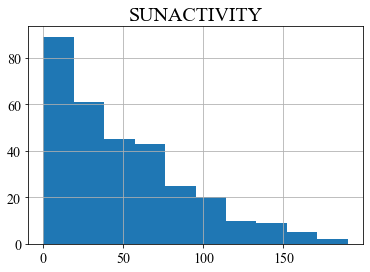

In [60]:
sunspots_data = sma.datasets.sunspots.load_pandas().data
sunspots_data.hist("SUNACTIVITY")

In [61]:
def likelihood_ratio_test(frequences_observed, frequences_predicted):
    statistic = 2 * np.sum(np.log(frequences_observed / frequences_predicted))
    pvalue = 1 - sps.chi.cdf(statistic, len(frequences_observed) - 1)
    return statistic, pvalue

Got statistic = 1.163 with p-value = 0.998, fail to reject HM


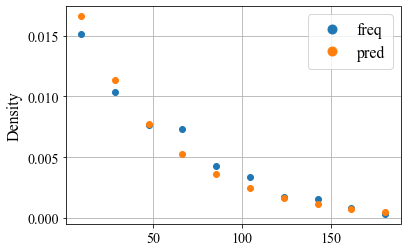

In [62]:
bins = 10

x = sunspots_data["SUNACTIVITY"].values
frequences, grid = np.histogram(x, bins=bins, density=True)
points = (grid[1:] + grid[:-1]) / 2

lam = x.mean()
dist_pred = sps.expon(loc=0, scale=lam)

plt.plot(points, frequences, "o", label="freq")
plt.plot(points, dist_pred.pdf(points), "o", label="pred")
plt.legend()
plt.grid(True)
plt.ylabel("Density")

statistic, pvalue = likelihood_ratio_test(frequences, dist_pred.pdf(points))

print(f"Got statistic = {statistic:.3f} with p-value = {pvalue:.3f}, {'fail to' if pvalue > 0.05 else ''} reject HM")

## Multiple testing

### Bonferroni and Benjamini-Hochberg methods
[docs](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html)

In [63]:
from statsmodels.stats.multitest import multipletests

Let's look, how long we should observe temperature to predict mean for all years accurate enough.

In [ ]:
estimation_period = 8 # years
pvalues_ttest = []
for month in elnino_data.columns:
    x = elnino_data[month].values
    hypothesis_mean = np.mean(x[:estimation_period])
    pvalues_ttest += [sps.ttest_1samp(x, hypothesis_mean)[1]]

print("T-test")    
for method in ["bonferroni", "fdr_bh"]:
    
    reject, pvals, _, _ = multipletests(pvalues_ttest, method=method, returnsorted=True)
    print(f"Method {method:10s}: reject=\n{reject}\n with p-values = \n{pvals}")

T-test
Method bonferroni: reject=
[ True  True  True  True  True False False False False False False False]
 with p-values = 
[2.70414317e-07 1.87254196e-04 2.69514642e-03 3.53464064e-03
 5.77122685e-03 1.03748284e-01 1.11521106e-01 7.83155632e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]
Method fdr_bh    : reject=
[ True  True  True  True  True  True  True False False False False False]
 with p-values = 
[2.70414317e-07 9.36270981e-05 8.83660160e-04 8.83660160e-04
 1.15424537e-03 1.59315866e-02 1.59315866e-02 9.78944541e-02
 2.24037368e-01 2.98100954e-01 4.17473994e-01 4.17473994e-01]
